<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/V5_Tomato_dataset_with_confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d manjuphoenix/tomatodataset

 99% 917M/923M [00:05<00:00, 179MB/s]
100% 923M/923M [00:05<00:00, 167MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a test set is: 19488
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [ ]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
#         self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
#         self.mish2 = nn.Mish()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
#         self.cnn3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
#         self.relu3 = nn.ReLU()
#         self.mish2 = nn.Mish()
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 1000)
        self.fc2 = nn.Linear(1000, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
#         out = self.mish1(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
#         out = self.mish2(out)
        out = self.maxpool2(out)
#         out = self.cnn3(out)
#         out = self.relu3(out)
#         out = self.maxpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0003
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [ ]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [ ]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

# optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [ ]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=60
for epoch in range(1,int(epochs)+1):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  


Epoch : 1


100%|██████████| 2841/2841 [05:05<00:00,  9.30it/s]


Train Loss: 1.999 | Accuracy: 26.322


100%|██████████| 609/609 [01:03<00:00,  9.62it/s]


Test Loss: 1.872 | Accuracy: 34.300

Epoch : 2


100%|██████████| 2841/2841 [05:06<00:00,  9.28it/s]


Train Loss: 1.764 | Accuracy: 37.198


100%|██████████| 609/609 [01:03<00:00,  9.62it/s]


Test Loss: 1.676 | Accuracy: 42.067

Epoch : 3


100%|██████████| 2841/2841 [05:06<00:00,  9.26it/s]


Train Loss: 1.631 | Accuracy: 42.688


100%|██████████| 609/609 [01:04<00:00,  9.49it/s]


Test Loss: 1.581 | Accuracy: 46.620

Epoch : 4


100%|██████████| 2841/2841 [05:05<00:00,  9.28it/s]


Train Loss: 1.547 | Accuracy: 47.006


100%|██████████| 609/609 [01:03<00:00,  9.58it/s]


Test Loss: 1.499 | Accuracy: 47.046

Epoch : 5


100%|██████████| 2841/2841 [05:07<00:00,  9.24it/s]


Train Loss: 1.441 | Accuracy: 50.680


100%|██████████| 609/609 [01:03<00:00,  9.57it/s]


Test Loss: 1.374 | Accuracy: 52.841

Epoch : 6


100%|██████████| 2841/2841 [05:06<00:00,  9.28it/s]


Train Loss: 1.339 | Accuracy: 53.687


100%|██████████| 609/609 [01:03<00:00,  9.65it/s]


Test Loss: 1.262 | Accuracy: 56.727

Epoch : 7


100%|██████████| 2841/2841 [05:05<00:00,  9.30it/s]


Train Loss: 1.262 | Accuracy: 55.697


100%|██████████| 609/609 [01:03<00:00,  9.61it/s]


Test Loss: 1.203 | Accuracy: 57.584

Epoch : 8


100%|██████████| 2841/2841 [05:05<00:00,  9.29it/s]


Train Loss: 1.192 | Accuracy: 58.251


100%|██████████| 609/609 [01:03<00:00,  9.65it/s]


Test Loss: 1.141 | Accuracy: 59.283

Epoch : 9


100%|██████████| 2841/2841 [05:07<00:00,  9.23it/s]


Train Loss: 1.135 | Accuracy: 60.043


100%|██████████| 609/609 [01:02<00:00,  9.71it/s]


Test Loss: 1.091 | Accuracy: 60.479

Epoch : 10


100%|██████████| 2841/2841 [05:05<00:00,  9.31it/s]


Train Loss: 1.076 | Accuracy: 61.794


100%|██████████| 609/609 [01:03<00:00,  9.57it/s]


Test Loss: 1.077 | Accuracy: 62.096

Epoch : 11


100%|██████████| 2841/2841 [05:02<00:00,  9.39it/s]


Train Loss: 1.034 | Accuracy: 63.463


100%|██████████| 609/609 [01:03<00:00,  9.66it/s]


Test Loss: 1.026 | Accuracy: 64.524

Epoch : 12


100%|██████████| 2841/2841 [05:06<00:00,  9.27it/s]


Train Loss: 1.000 | Accuracy: 64.514


100%|██████████| 609/609 [01:03<00:00,  9.52it/s]


Test Loss: 1.014 | Accuracy: 62.733

Epoch : 13


100%|██████████| 2841/2841 [05:06<00:00,  9.28it/s]


Train Loss: 0.959 | Accuracy: 65.832


100%|██████████| 609/609 [01:04<00:00,  9.43it/s]


Test Loss: 0.931 | Accuracy: 66.439

Epoch : 14


100%|██████████| 2841/2841 [05:04<00:00,  9.32it/s]


Train Loss: 0.916 | Accuracy: 67.422


100%|██████████| 609/609 [01:02<00:00,  9.70it/s]


Test Loss: 0.876 | Accuracy: 68.672

Epoch : 15


100%|██████████| 2841/2841 [05:02<00:00,  9.39it/s]


Train Loss: 0.865 | Accuracy: 69.262


100%|██████████| 609/609 [01:02<00:00,  9.67it/s]


Test Loss: 0.853 | Accuracy: 69.622

Epoch : 16


100%|██████████| 2841/2841 [05:02<00:00,  9.38it/s]


Train Loss: 0.829 | Accuracy: 70.519


100%|██████████| 609/609 [01:02<00:00,  9.75it/s]


Test Loss: 0.832 | Accuracy: 69.940

Epoch : 17


100%|██████████| 2841/2841 [05:02<00:00,  9.38it/s]


Train Loss: 0.788 | Accuracy: 71.924


100%|██████████| 609/609 [01:03<00:00,  9.53it/s]


Test Loss: 0.741 | Accuracy: 73.092

Epoch : 18


100%|██████████| 2841/2841 [05:02<00:00,  9.38it/s]


Train Loss: 0.754 | Accuracy: 73.093


100%|██████████| 609/609 [01:03<00:00,  9.63it/s]


Test Loss: 0.724 | Accuracy: 74.375

Epoch : 19


100%|██████████| 2841/2841 [05:05<00:00,  9.29it/s]


Train Loss: 0.726 | Accuracy: 74.249


100%|██████████| 609/609 [01:02<00:00,  9.73it/s]


Test Loss: 0.694 | Accuracy: 74.955

Epoch : 20


100%|██████████| 2841/2841 [05:04<00:00,  9.33it/s]


Train Loss: 0.702 | Accuracy: 74.965


100%|██████████| 609/609 [01:03<00:00,  9.54it/s]


Test Loss: 0.733 | Accuracy: 73.939

Epoch : 21


100%|██████████| 2841/2841 [05:03<00:00,  9.36it/s]


Train Loss: 0.679 | Accuracy: 75.771


100%|██████████| 609/609 [01:02<00:00,  9.68it/s]


Test Loss: 0.646 | Accuracy: 76.901

Epoch : 22


100%|██████████| 2841/2841 [05:03<00:00,  9.37it/s]


Train Loss: 0.665 | Accuracy: 76.244


100%|██████████| 609/609 [01:03<00:00,  9.62it/s]


Test Loss: 0.636 | Accuracy: 77.614

Epoch : 23


100%|██████████| 2841/2841 [05:03<00:00,  9.35it/s]


Train Loss: 0.646 | Accuracy: 76.835


100%|██████████| 609/609 [01:03<00:00,  9.65it/s]


Test Loss: 0.613 | Accuracy: 78.225

Epoch : 24


100%|██████████| 2841/2841 [05:05<00:00,  9.30it/s]


Train Loss: 0.633 | Accuracy: 77.315


100%|██████████| 609/609 [01:02<00:00,  9.71it/s]


Test Loss: 0.626 | Accuracy: 77.532

Epoch : 25


100%|██████████| 2841/2841 [05:04<00:00,  9.32it/s]


Train Loss: 0.624 | Accuracy: 77.613


100%|██████████| 609/609 [01:03<00:00,  9.63it/s]


Test Loss: 0.602 | Accuracy: 78.389

Epoch : 26


100%|██████████| 2841/2841 [05:04<00:00,  9.32it/s]


Train Loss: 0.618 | Accuracy: 77.929


100%|██████████| 609/609 [01:03<00:00,  9.54it/s]


Test Loss: 0.589 | Accuracy: 79.231

Epoch : 27


100%|██████████| 2841/2841 [05:03<00:00,  9.36it/s]


Train Loss: 0.604 | Accuracy: 78.340


100%|██████████| 609/609 [01:02<00:00,  9.79it/s]


Test Loss: 0.596 | Accuracy: 78.066

Epoch : 28


100%|██████████| 2841/2841 [05:04<00:00,  9.32it/s]


Train Loss: 0.593 | Accuracy: 78.703


100%|██████████| 609/609 [01:04<00:00,  9.51it/s]


Test Loss: 0.587 | Accuracy: 79.139

Epoch : 29


100%|██████████| 2841/2841 [05:04<00:00,  9.33it/s]


Train Loss: 0.586 | Accuracy: 78.952


100%|██████████| 609/609 [01:02<00:00,  9.72it/s]


Test Loss: 0.616 | Accuracy: 78.076

Epoch : 30


100%|██████████| 2841/2841 [05:05<00:00,  9.30it/s]


Train Loss: 0.580 | Accuracy: 79.244


100%|██████████| 609/609 [01:02<00:00,  9.72it/s]


Test Loss: 0.576 | Accuracy: 79.749

Epoch : 31


100%|██████████| 2841/2841 [05:04<00:00,  9.32it/s]


Train Loss: 0.575 | Accuracy: 79.448


100%|██████████| 609/609 [01:03<00:00,  9.53it/s]


Test Loss: 0.607 | Accuracy: 77.984

Epoch : 32


100%|██████████| 2841/2841 [05:04<00:00,  9.34it/s]


Train Loss: 0.561 | Accuracy: 79.936


100%|██████████| 609/609 [01:04<00:00,  9.49it/s]


Test Loss: 0.556 | Accuracy: 80.237

Epoch : 33


100%|██████████| 2841/2841 [05:03<00:00,  9.36it/s]


Train Loss: 0.554 | Accuracy: 80.261


100%|██████████| 609/609 [01:03<00:00,  9.63it/s]


Test Loss: 0.537 | Accuracy: 80.904

Epoch : 34


100%|██████████| 2841/2841 [05:05<00:00,  9.29it/s]


Train Loss: 0.549 | Accuracy: 80.426


100%|██████████| 609/609 [01:02<00:00,  9.71it/s]


Test Loss: 0.540 | Accuracy: 80.843

Epoch : 35


100%|██████████| 2841/2841 [05:04<00:00,  9.34it/s]


Train Loss: 0.549 | Accuracy: 80.469


100%|██████████| 609/609 [01:02<00:00,  9.71it/s]


Test Loss: 0.535 | Accuracy: 80.925

Epoch : 36


100%|██████████| 2841/2841 [05:04<00:00,  9.33it/s]


Train Loss: 0.540 | Accuracy: 80.598


100%|██████████| 609/609 [01:02<00:00,  9.78it/s]


Test Loss: 0.543 | Accuracy: 80.458

Epoch : 37


100%|██████████| 2841/2841 [05:03<00:00,  9.36it/s]


Train Loss: 0.537 | Accuracy: 80.849


100%|██████████| 609/609 [01:02<00:00,  9.69it/s]


Test Loss: 0.518 | Accuracy: 81.505

Epoch : 38


100%|██████████| 2841/2841 [05:04<00:00,  9.32it/s]


Train Loss: 0.534 | Accuracy: 81.038


100%|██████████| 609/609 [01:02<00:00,  9.78it/s]


Test Loss: 0.512 | Accuracy: 81.977

Epoch : 39


100%|██████████| 2841/2841 [05:02<00:00,  9.39it/s]


Train Loss: 0.530 | Accuracy: 81.320


100%|██████████| 609/609 [01:03<00:00,  9.56it/s]


Test Loss: 0.528 | Accuracy: 81.408

Epoch : 40


100%|██████████| 2841/2841 [05:01<00:00,  9.42it/s]


Train Loss: 0.524 | Accuracy: 81.377


100%|██████████| 609/609 [01:02<00:00,  9.78it/s]


Test Loss: 0.500 | Accuracy: 82.516

Epoch : 41


100%|██████████| 2841/2841 [04:58<00:00,  9.52it/s]


Train Loss: 0.518 | Accuracy: 81.644


100%|██████████| 609/609 [01:01<00:00,  9.88it/s]


Test Loss: 0.528 | Accuracy: 81.479

Epoch : 42


100%|██████████| 2841/2841 [04:58<00:00,  9.51it/s]


Train Loss: 0.511 | Accuracy: 81.714


100%|██████████| 609/609 [01:01<00:00,  9.92it/s]


Test Loss: 0.498 | Accuracy: 82.383

Epoch : 43


100%|██████████| 2841/2841 [04:56<00:00,  9.58it/s]


Train Loss: 0.512 | Accuracy: 81.789


100%|██████████| 609/609 [01:01<00:00,  9.83it/s]


Test Loss: 0.493 | Accuracy: 82.521

Epoch : 44


100%|██████████| 2841/2841 [04:56<00:00,  9.58it/s]


Train Loss: 0.510 | Accuracy: 82.000


100%|██████████| 609/609 [01:01<00:00,  9.91it/s]


Test Loss: 0.504 | Accuracy: 82.034

Epoch : 45


100%|██████████| 2841/2841 [04:56<00:00,  9.58it/s]


Train Loss: 0.502 | Accuracy: 82.183


100%|██████████| 609/609 [01:01<00:00,  9.97it/s]


Test Loss: 0.512 | Accuracy: 81.762

Epoch : 46


100%|██████████| 2841/2841 [04:55<00:00,  9.60it/s]


Train Loss: 0.500 | Accuracy: 82.230


100%|██████████| 609/609 [01:01<00:00,  9.98it/s]


Test Loss: 0.504 | Accuracy: 82.383

Epoch : 47


100%|██████████| 2841/2841 [04:58<00:00,  9.50it/s]


Train Loss: 0.492 | Accuracy: 82.421


100%|██████████| 609/609 [01:01<00:00,  9.89it/s]


Test Loss: 0.477 | Accuracy: 83.122

Epoch : 48


100%|██████████| 2841/2841 [04:59<00:00,  9.49it/s]


Train Loss: 0.488 | Accuracy: 82.740


100%|██████████| 609/609 [01:02<00:00,  9.79it/s]


Test Loss: 0.524 | Accuracy: 81.336

Epoch : 49


100%|██████████| 2841/2841 [05:05<00:00,  9.31it/s]


Train Loss: 0.490 | Accuracy: 82.560


100%|██████████| 609/609 [01:03<00:00,  9.65it/s]


Test Loss: 0.513 | Accuracy: 81.926

Epoch : 50


100%|██████████| 2841/2841 [05:03<00:00,  9.36it/s]


Train Loss: 0.490 | Accuracy: 82.728


100%|██████████| 609/609 [01:02<00:00,  9.70it/s]


Test Loss: 0.472 | Accuracy: 83.214

Epoch : 51


100%|██████████| 2841/2841 [05:04<00:00,  9.32it/s]


Train Loss: 0.484 | Accuracy: 82.957


100%|██████████| 609/609 [01:02<00:00,  9.80it/s]


Test Loss: 0.474 | Accuracy: 82.973

Epoch : 52


100%|██████████| 2841/2841 [05:01<00:00,  9.43it/s]


Train Loss: 0.480 | Accuracy: 83.021


100%|██████████| 609/609 [01:02<00:00,  9.76it/s]


Test Loss: 0.468 | Accuracy: 83.261

Epoch : 53


100%|██████████| 2841/2841 [05:01<00:00,  9.41it/s]


Train Loss: 0.477 | Accuracy: 83.081


100%|██████████| 609/609 [01:02<00:00,  9.81it/s]


Test Loss: 0.461 | Accuracy: 83.682

Epoch : 54


100%|██████████| 2841/2841 [05:00<00:00,  9.45it/s]


Train Loss: 0.483 | Accuracy: 82.893


100%|██████████| 609/609 [01:02<00:00,  9.81it/s]


Test Loss: 0.468 | Accuracy: 83.548

Epoch : 55


100%|██████████| 2841/2841 [04:59<00:00,  9.47it/s]


Train Loss: 0.470 | Accuracy: 83.443


100%|██████████| 609/609 [01:02<00:00,  9.74it/s]


Test Loss: 0.492 | Accuracy: 82.614

Epoch : 56


100%|██████████| 2841/2841 [04:59<00:00,  9.50it/s]


Train Loss: 0.462 | Accuracy: 83.589


100%|██████████| 609/609 [01:01<00:00,  9.89it/s]


Test Loss: 0.485 | Accuracy: 82.511

Epoch : 57


100%|██████████| 2841/2841 [04:58<00:00,  9.52it/s]


Train Loss: 0.465 | Accuracy: 83.568


100%|██████████| 609/609 [01:01<00:00,  9.86it/s]


Test Loss: 0.515 | Accuracy: 81.582

Epoch : 58


100%|██████████| 2841/2841 [04:58<00:00,  9.51it/s]


Train Loss: 0.463 | Accuracy: 83.461


100%|██████████| 609/609 [01:02<00:00,  9.75it/s]


Test Loss: 0.451 | Accuracy: 84.082

Epoch : 59


100%|██████████| 2841/2841 [04:57<00:00,  9.55it/s]


Train Loss: 0.467 | Accuracy: 83.432


100%|██████████| 609/609 [01:02<00:00,  9.78it/s]


Test Loss: 0.446 | Accuracy: 84.631

Epoch : 60


100%|██████████| 2841/2841 [05:04<00:00,  9.34it/s]


Train Loss: 0.459 | Accuracy: 83.902


100%|██████████| 609/609 [01:03<00:00,  9.56it/s]

Test Loss: 0.480 | Accuracy: 82.716


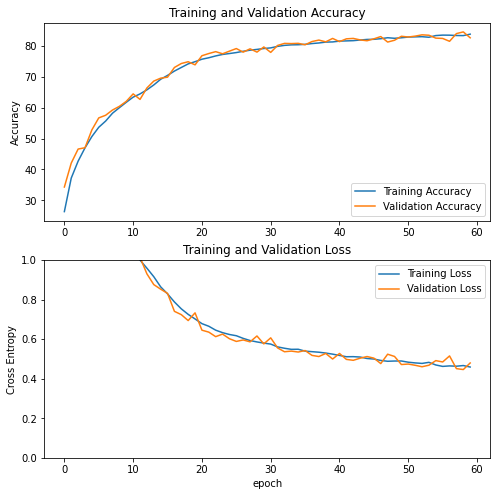

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Tomato_Target_spot : 80 %
Accuracy of Tomato__Late_blight : 77 %
Accuracy of Tomato__Septoria_leaf_spot : 72 %
Accuracy of Tomato__Spider_mites : 74 %
Accuracy of Tomato___Bacterial_spot : 98 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 94 %
Accuracy of Tomato__early_blight : 68 %
Accuracy of Tomato__healthy : 96 %


In [ ]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

Average accuracy =  82.44007240801498


In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v3_tomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v3_tomato_scripted.pt') # Save

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[1944   37   34  169   49    2   65   95]
 [  25 1829   54   38  117   36  289   20]
 [ 101  188 1744   57   42   21  164   69]
 [ 271   39   26 1811   33   40  125   32]
 [   0    5    1    0 2505   55    3    1]
 [   3   14    0    2  132 2376    5    1]
 [ 133  352   53   68  108   40 1619    8]
 [  28   18   11   14   21    0    2 2337]]
[81.1691023  75.9551495  73.09304275 76.18847286 97.47081712 93.80181603
 67.99664007 96.13327849]
